In [50]:
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.neighbors import KDTree
from tqdm import tqdm
import scipy.stats as stats
import json
from sklearn.metrics import mean_squared_error
import nolds
from itertools import permutations
from imageio import imread

In [21]:
lorenz = np.loadtxt('lorenz.txt')

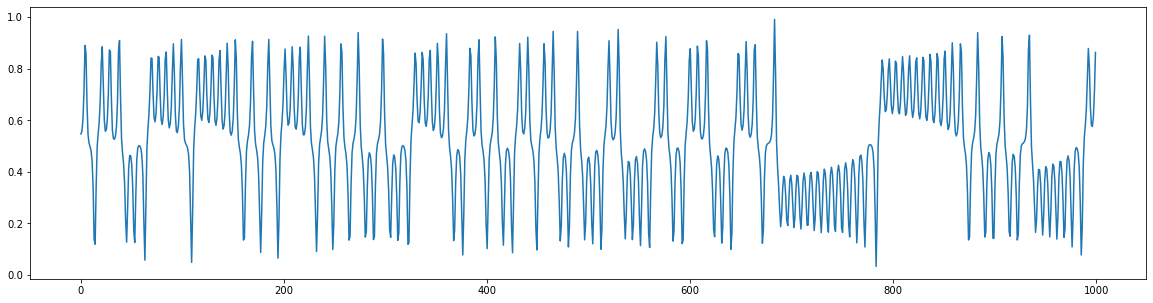

In [22]:
plt.figure(figsize=(20, 5))
plt.plot(lorenz[-1000:])

In [23]:
def norm2(v1, v2):
    norm = 0
    for i in range(len(v1)):
        norm += (v1[i] - v2[i])**2
    return np.sqrt(norm)

def to_z(x, template):
    N = len(x)
    z = []
    for i in range(N - sum(template)):
        ind = i
        v = [x[ind]]
        for j in template:
            ind += j
            v.append(x[ind])
        z.append(v)
    return np.array(z)

In [24]:
x = lorenz[-10000:]
z = to_z(x, [1, 1, 1])

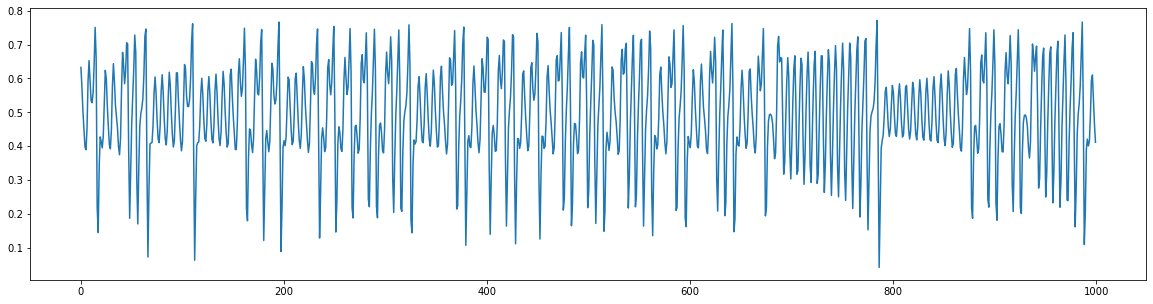

In [25]:
ampls = [np.sqrt(np.sum(i**2)) for i in z]
x_norm = x[:-3] / ampls
plt.figure(figsize=(20, 5))
plt.plot(x_norm[-1000:])

In [26]:
def f_lorenz(x, y, z, s=10, r=28, b=8/3):
    x_dot = s*(y - x)
    y_dot = r*x - y - x*z
    z_dot = x*y - b*z
    return np.array([x_dot, y_dot, z_dot])

In [27]:
def runge_kutta(n, f, y0, h=0.1):
    y = [np.array(y0)]
    for i in range(n):
        k1 = f(*y[-1])
        k2 = f(*y[-1] + k1*h/2)
        k3 = f(*y[-1] + k2*h/2)
        k4 = f(*y[-1] + k3*h)
        y.append(y[-1] + (k1 + 2*k2 + 2*k3 + k4)*h/6)
    y = np.array(y)
    return y.T

In [47]:
m = 20

x = lorenz[-10000:]
z = to_z(x, [1, 1, 1])
tree = KDTree(z[:-m])
dists, inds = tree.query(z[:-m], 2)
dists = dists[:, -1]
inds = inds[:, -1]
ll = []
for i in range(len(inds)):
    if dists[i] >= 0.01:
        continue
    e0 = dists[i]
    em = norm2(z[i + m], z[inds[i] + m])
    ll.append(1/m*np.log(em/e0))
lyap_exp = np.mean(ll)
print('Показатель Ляпунова: %.2f' % lyap_exp)

Показатель Ляпунова: 0.13


In [29]:
lyap_exp = nolds.lyap_r(x, lag=1, emb_dim=4)
print('Показатель Ляпунова: %.2f' % lyap_exp)

C:\Users\andre\anaconda3\lib\site-packages\nolds\measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 2500
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


Показатель Ляпунова: 0.12


In [30]:
e0 = 1e-4
emax = 1e-1
T = int(1/lyap_exp*np.log(emax/e0))
print('Горизонт прогнозирования: %d' % T)

Горизонт прогнозирования: 59


In [31]:
def permutations_p(x, dim=4):

    z = to_z(x, [1, 1, 1])
    all_permutations = np.array(list(permutations(range(dim))))

    p = np.zeros(np.math.factorial(dim))

    for _z in z:
        permutation = np.argsort(_z)
        permutation_idx = np.where((all_permutations == permutation).all(axis=1))[0][0]
        p[permutation_idx] = p[permutation_idx] + 1

    p = p/p.sum()

    return p

def entropy(p):
    return -(np.log(p[p!=0])*p[p!=0]).sum()

def normalized_entropy(p, dim=4):
    M = np.math.factorial(dim)
    S = entropy(p)
    return S/np.log(M)

def jensen_shannon_div(p, dim=4):
    M = np.math.factorial(dim)
    p_e = np.ones(M)
    p_e = p_e / p_e.sum()
    J = entropy((p+p_e)/2) - entropy(p)/2 - entropy(p_e)/2
    return J


def disequilibrium(p, dim=4):
    M = np.math.factorial(dim)
    Q_0 = -2 * ((((M + 1) / M) * np.log(M + 1) - 2 * np.log(2 * M) + np.log(M)) ** (-1))
    Q_j = Q_0 * jensen_shannon_div(p, dim)
    C = Q_j * normalized_entropy(p, dim)
    return C

In [32]:
p = permutations_p(x)
entropy_norm = normalized_entropy(p)
complexity = disequilibrium(p)

In [33]:
print('Значение пары энтропия - сложность: %.2f - %.2f' % (entropy_norm, complexity))

Значение пары энтропия - сложность: 0.63 - 0.30


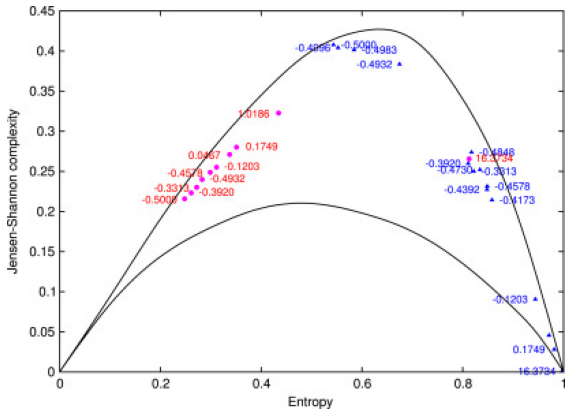

In [54]:
img = imread('sc.jpg')
plt.figure(figsize=(10, 10))
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

In [34]:
def dist_kneighbor(z, k):
    tree = KDTree(z)
    dist, indexes = tree.query(z, k)
    return dist[:, -1]

def density(dist, p, k):
    N = len(dist)
    
    pp = p // 2
    if p % 2 == 0:
        c = np.power(np.pi, pp) / np.math.factorial(pp)
    else:
        c = 2 * np.power(2 * np.pi, pp)
        i = p
        while i > 0:
            c /= i
            i -= 2
            
    return k / N / (c * np.power(dist, p))

def check_significance(dens, h):
    if dens[0] - dens[-1] >= h:
        return True
    return False

In [35]:
def wishart(z, h=0.01):
    '''
    z: shape (N, p)
    '''
    N = z.shape[0]
    p = z.shape[1]
    k = int(N**0.5)
    
    dist = dist_kneighbor(z, k)
    sort_idx = np.argsort(dist)
    
    dist_sort = dist[sort_idx]
    z_sort = z[sort_idx]
    dens_sort = density(dist_sort, p, k)
    
    clusters = np.zeros(N)
    formed_clusters = set()
    clusters_count = 1
    
    tree = KDTree(z_sort)
    indexes_sort = tree.query(z_sort, k, return_distance=False)
    
    for i in range(N):
        neighbors = [j for j in indexes_sort[i] if j < i]
        nclusters = set(clusters[j] for j in neighbors)
        
        if len(nclusters) == 0:
            clusters[i] = clusters_count
            clusters_count += 1
        elif len(nclusters) == 1:
            l = list(nclusters)[0]
            if l not in formed_clusters:
                clusters[i] = l
        else:
            if nclusters.issubset(formed_clusters):
                continue
            formed_nclusters = nclusters & formed_clusters
            unformed_nclusters = nclusters - formed_clusters
            sign_unformed_nclusters = set(
                j for j in unformed_nclusters
                if j != 0 and check_significance(dens_sort[clusters == j], h)
            )
            nsc = len(formed_nclusters) + len(sign_unformed_nclusters)
            if nsc > 1 or 0 in nclusters:
                formed_clusters.update(sign_unformed_nclusters)
                for j in unformed_nclusters - sign_unformed_nclusters:
                    clusters[clusters == j] = 0
            else:
                l = np.sort(list(nclusters))[0]
                clusters[i] = l
                for j in nclusters:
                    if j != l:
                        clusters[clusters == j] = l

    return clusters[np.argsort(sort_idx)]

def template_to_str(i, j, k):
    return str(i) + ' ' + str(j) + ' ' + str(k)

In [36]:
x_train = lorenz[-10000:-1000]
x_test = lorenz[-1000:]

In [9]:
clusters_c_dict = {}
n = len(x_train)
for i in tqdm(range(1, 11)):
    for j in range(i + 1, i + 11):
        for k in range(j + 1, j + 11):
            template = template_to_str(i, j, k)
            z = []
            for start in range(n - k):
                z.append([x_train[start], x_train[start + i], x_train[start + j], x_train[start + k]])
            z = np.array(z)
            clusters = wishart(z)
            clusters_c = [list(z[clusters == i].mean(axis=0)) for i in np.unique(clusters)
                          if i != 0 and np.sum(clusters == i) > 6]
            
            clusters_c_dict[template] = clusters_c

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [19:31<00:00, 117.11s/it]


In [10]:
with open('clusters_c_dict.json', 'w') as f:
    json.dump(clusters_c_dict, f)

In [37]:
with open('clusters_c_dict.json', 'r') as f:
    clusters_c_dict = json.load(f)

In [38]:
def check_possibility(counts, k=1/2):
    num = np.argmax(counts)
    if num == 0:
        pind = [0, 1]
    elif num == len(counts) - 1:
        pind = [num - 1, num]
    else:
        pind = [num - 1, num, num + 1]
    if np.any(np.delete(counts, pind) > k*counts[num]):
        return False
    return True

def predict_wishart(x_test_exp, step, w=0):
    #pp = []
    predicts = []
    for q in range(w, w + step):
        possible_predicts = []
        for i in range(1, 11):
            for j in range(i + 1, i + 11):
                for k in range(j + 1, j + 11):
                    if not x_test_exp[q - k] or not x_test_exp[q - k + i] or not x_test_exp[q - k + j]:
                        continue
                    v = [x_test_exp[q - k], x_test_exp[q - k + i], x_test_exp[q - k + j]]
                    template = template_to_str(i, j, k)
                    clusters_c = np.array(clusters_c_dict[template])
                    indbest = 0
                    normbest = norm2(clusters_c[0, :-1], v)
                    for ind in range(1, len(clusters_c)):
                        norm = norm2(clusters_c[ind, :-1], v)
                        if norm < normbest:
                            normbest = norm
                            indbest = ind
                    possible_predict = clusters_c[indbest, -1]
                    possible_predicts.append(possible_predict)
        
        #pp.append(possible_predicts)
        counts, values = np.histogram(possible_predicts)
        predict = values[np.argmax(counts)] if check_possibility(counts) else None

        #if not predict:
        #    unpredictable += 1

        x_test_exp[q] = predict
        predicts.append(predict)

    return predicts#, np.reshape(pp, (step, 1000))

Text(0.5, 1.0, 'Прогноз на 1 шаг без непрогнозируемых точек')

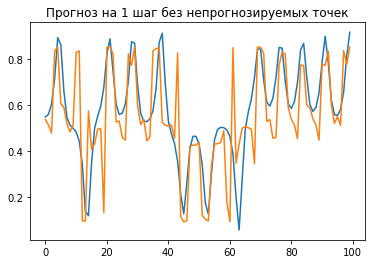

In [228]:
step = 1
predicts = [predict_wishart(np.append(x_test, x_train[-30:]), step, w)[0] for w in range(100)]
plt.plot(x_test[:100])
plt.plot(predicts)
plt.title('Прогноз на 1 шаг без непрогнозируемых точек')
plt.show()

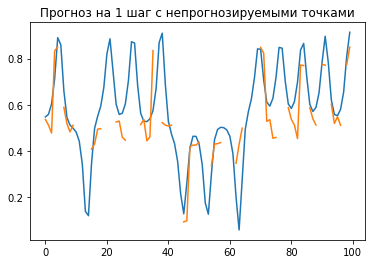

In [78]:
step = 1
predicts = [predict_wishart(np.append(x_test, x_train[-30:]), step, w)[0] for w in range(100)]
plt.plot(x_test[:100])
plt.plot(predicts)
plt.title('Прогноз на 1 шаг с непрогнозируемыми точками')
plt.show()

Text(0.5, 1.0, 'Прогноз на 30 шагов без непрогнозируемых точек')

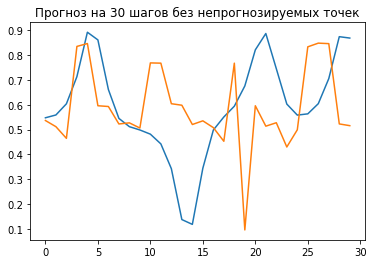

In [168]:
step = 30
w = 0
predicts = predict_wishart(np.append(x_test, x_train[-30:]), step, w)
plt.plot(x_test[:step])
plt.plot(predicts)
plt.title('Прогноз на 30 шагов без непрогнозируемых точек')
plt.show()

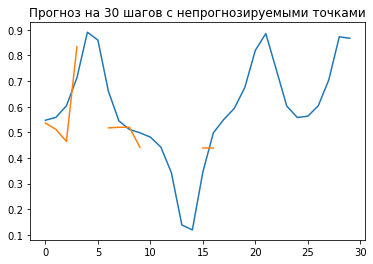

In [79]:
step = 30
w = 0
predicts = predict_wishart(np.append(x_test, x_train[-30:]), step, w)
plt.plot(x_test[w:w+step])
plt.plot(predicts)
plt.title('Прогноз на 30 шагов с непрогнозируемыми точками')
plt.show()

In [41]:
steps = np.arange(1, 31)

In [173]:
n = len(x_test)

rmse_step = []
mape_step = []
unpredictable_step = []

for step in tqdm(steps):
    #t = time.time()
    rmses = []
    mapes = []
    unpredictables = []
    for w in range(0, n - step + 1, step): # цикл по кускам одной длины
        unpredictable = 0
        predicts = []
        trues = x_test[w:w+step]
        x_test_exp = np.append(x_test, x_train[-30:])
        x_test_exp = list(x_test_exp)
        for q in range(w, w + step): # цикл по одному куску
            possible_predicts = []
            for i in range(1, 11):
                for j in range(i + 1, i + 11):
                    for k in range(j + 1, j + 11):
                        if not x_test_exp[q - k] or not x_test_exp[q - k + i] or not x_test_exp[q - k + j]:
                            continue
                        v = [x_test_exp[q - k], x_test_exp[q - k + i], x_test_exp[q - k + j]]
                        template = template_to_str(i, j, k)
                        clusters_c = np.array(clusters_c_dict[template])
                        indbest = 0
                        normbest = norm2(clusters_c[0, :-1], v)
                        for ind in range(1, len(clusters_c)):
                            norm = norm2(clusters_c[ind, :-1], v)
                            if norm < normbest:
                                normbest = norm
                                indbest = ind
                        possible_predict = clusters_c[indbest, -1]
                        possible_predicts.append(possible_predict)

            counts, values = np.histogram(possible_predicts)
            predict = values[np.argmax(counts)] if check_possibility(counts) else None

            if not predict:
                unpredictable += 1

            x_test_exp[q] = predict
            predicts.append(predict)

        predicts = np.array(predicts)
        real_predicts = predicts[predicts != np.array(None)]
        real_trues = trues[predicts != np.array(None)]

        if len(real_predicts) == 0:
            continue
        
        unpredictables.append(unpredictable)
        rmses.append(np.sqrt(mean_squared_error(real_trues, real_predicts)))
        mapes.append(np.mean(np.abs((real_trues - real_predicts) / real_trues)) * 100)
    
    rmse_step.append(np.mean(rmses))
    mape_step.append(np.mean(mapes))
    unpredictable_step.append(np.mean(unpredictables))
    
    #print('Step %d: %.2fs' % (step, time.time() - t))

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [43:03<00:00, 86.12s/it]


In [178]:
np.savetxt('k_1.txt', [rmse_step, mape_step, unpredictable_step])

In [39]:
rmse_step_1, mape_step_1, unpredictable_step_1 = np.loadtxt('k_1.txt')
rmse_step, mape_step, unpredictable_step = np.loadtxt('k_1_2.txt')

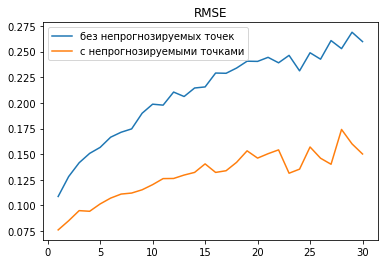

In [42]:
plt.plot(steps, rmse_step_1, label='без непрогнозируемых точек')
plt.plot(steps, rmse_step, label='с непрогнозируемыми точками')
plt.title('RMSE')
plt.legend()
plt.show()

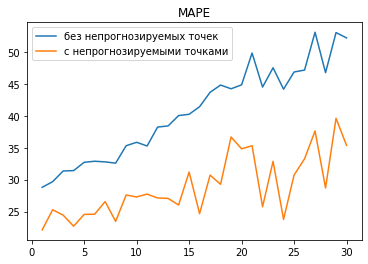

In [43]:
plt.plot(steps, mape_step_1, label='без непрогнозируемых точек')
plt.plot(steps, mape_step, label='с непрогнозируемыми точками')
plt.title('MAPE')
plt.legend()
plt.show()

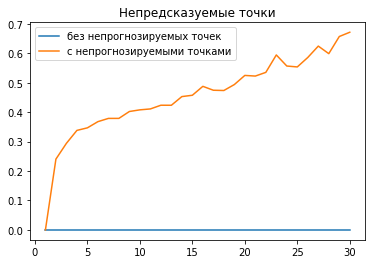

In [44]:
plt.plot(steps, unpredictable_step_1 / steps, label='без непрогнозируемых точек')
plt.plot(steps, unpredictable_step / steps, label='с непрогнозируемыми точками')
plt.title('Непредсказуемые точки')
plt.legend()
plt.show()